# `StableSpectralElements.jl` - 1D linear advection-diffusion example

We first need to load StableSpectralElements.jl and OrdinaryDiffEq, which handle the spatial and temporal components of the discretization, respectively. The packages on the second line are used in this example for visualization and displaying timing information.

In [19]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, Printf, TimerOutputs

We will solve the one-dimensional linear advection-diffusion equation
$$
\partial_t U(x,t) + \partial_x (a U(x,t) - b \partial_x U(x,t)) = 0,  \quad \forall\, (x, t) \in (0,L) \times (0,T),
$$
with $a = 1$, $b = 5 \times 10^{-2}$, $L = 1$, and $T = 1$, imposing periodic boundary conditions as well as the initial condition
$$
U(x,0) = \sin(2\pi x/L), \quad \forall \, x \in (0,L).
$$

In [20]:
a = 1.0  # wave speed
b = 5.0e-2  # diffusion coefficient
L = 1.0  # domain length
T = 1.0  # end time for one period

conservation_law = LinearAdvectionDiffusionEquation(a,b)
initial_data = InitialDataSine(1.0,2π/L)
exact_solution = ExactSolution(conservation_law,initial_data);

The problem described above will be discretized using a standard weak-form DG method of `NodalTensor` type on a uniform mesh with $M = 4$ elements of degree $p = 4$. The default options `inviscid_numerical_flux=LaxFriedrichsNumericalFlux()` and `viscous_numerical_flux=BR1()` are used, corresponding to the [Bassi-Rebay I viscous discretization](https://www.sciencedirect.com/science/article/abs/pii/S0021999196955722) for discontinuous Galerkin methods.

In [21]:
M = 4
p = 4
form = StandardForm()

reference_approximation = ReferenceApproximation(
    NodalTensor(p), Line())

mesh = uniform_periodic_mesh(reference_approximation, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);

We'll now save the project. This sets up a directory where intermediate solution files are saved, and allows the simulation to be resumed from a previous state.

In [22]:
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
     "results/advection_diffusion_1d/", clear=true, overwrite=true);

The function `semidiscretize` sets up the solver using the above parameters and uses it to construct an `ODEProblem` object. We can then use `solve` from OrdinaryDiffEq.jl to integrate in time. The five-stage, fourth-order low-storage explicit Runge-Kutta method from Carpenter and Kennedy is used for such a purpose. We use `save_callback` to write the solution to file 50 times during the course of the simulation.

In [23]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T), 
    PhysicalOperator())

CFL = 0.1
h = L / (reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / a

reset_timer!()
sol = solve(ode_problem, CarpenterKennedy2N54(), adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      149ms /  69.3%           22.8MiB /  89.3%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 rhs        1.07k    103ms  100.0%  96.5μs   20.4MiB  100.0%  19.5KiB
 ────────────────────────────────────────────────────────────────────


The $L^2$ norm of the error in the numerical solution can now be approximated, where we use an over-integrated quadrature rule in this case.

In [24]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization, LGQuadrature(p+2))
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)

L2 error:
2.0887513124400722e-5


Using the snapshots taken during the simulation, the discrete conservation and energy functionals can be evaluated, corresponding to the discrete approximations of $\int_0^L U(x,t) \, \mathrm{d} x$ and $\tfrac{1}{2}\int_0^L U(x,t)^2 \, \mathrm{d} x$, respectively. Note that the conservation functional remains constant up to machine precision, while the energy functional is nonincreasing for all time.

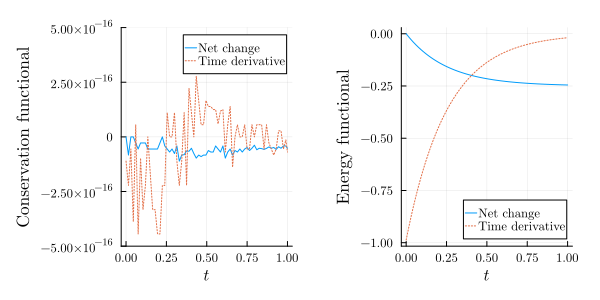

In [25]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation functional", ylims=[-5e-16, 5e-16])
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy functional");
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

We can plot the numerical solution at time $t = T$ and compare it to the analytical solution.

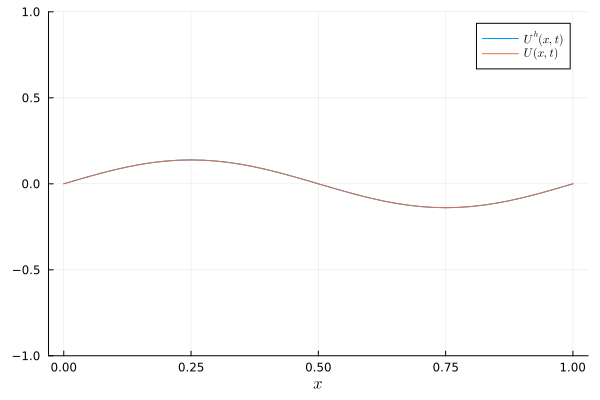

In [26]:
plot(spatial_discretization, last(sol.u), 
    exact_solution=exact_solution, time=T, ylims=[-1.0,1.0], fmt=:png)

Such plots can then be used to create an animation as shown below. We'll save it as a `.gif` file.

In [1]:
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], 
        ylims=[-1.0,1.0], ylabel="\$U^h(x,t)\$",
        label=string("\$t = \$", @sprintf "\$%.2f\$" sol.t[i]))
end
gif(anim, "figures/advection_diffusion_solution.gif", fps = 10)

LoadError: LoadError: UndefVarError: `@animate` not defined
in expression starting at In[1]:1